In [ ]:
from present import hide_code

hide_code()

In [ ]:
import api
from trello_metrics import get_tasks_due_on_date, get_past_due_tasks, get_cards_open_on_date, get_cards_closed_on_date, get_card_ages, get_x_oldest_cards
from date_utils import get_date_range
from present import css_table_formatting, print_cards, print_oldest_cards, create_today_tasks_table

import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt, mpld3
%matplotlib inline

# https://mpld3.github.io/index.html
# import mpld3
from mpld3 import plugins

# stuff needed for visualizations
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

css_table_formatting()
mpld3.enable_notebook()

FIG_WIDTH = 10
FIG_HEIGHT = 7

weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
days = mdates.DayLocator()
date_fmt = mdates.DateFormatter('%Y-%m-%d')

# display helper functions
def get_dates_and_task_counts(cards, days_ago):
    dates = []

    due_list = {}
    past_due_list = {}
    closed_list = {}
    
    for day in get_date_range(days_ago):
        due_tasks = list(get_tasks_due_on_date(cards, day))
        past_due_tasks = list(get_past_due_tasks(cards, day))
        closed_tasks = list(get_cards_closed_on_date(cards, day))
        
        dates.append(day)
        
        due_list[day] = due_tasks
        past_due_list[day] = past_due_tasks
        closed_list[day] = closed_tasks
        
    return dates, due_list, past_due_list, closed_list


def _get_task_counts(task_list):
    task_count = [len(tasks) for day, tasks in task_list.items()]
    return task_count
    

def get_dates_and_counts(list_id, days_ago=50):
    dates = []
    open_count = []
    close_count = []    
    
    all_cards = api.get_all_cards(list_id)
    for day in get_date_range(days_ago):
        open_item_count = len(list(get_cards_open_on_date(all_cards, day)))
        close_item_count = len(list(get_cards_closed_on_date(all_cards, day)))
        
        dates.append(day)
        open_count.append(open_item_count)
        close_count.append(close_item_count)
    
    return dates, open_count, close_count


def plot_histogram(card_ages, title):
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

    ax.hist(card_ages)
    ax.set(xlabel='Card age in days', ylabel='# of cards', title=title)
    plt.show()    
    

def create_past_due_labels(dates, past_due):
    table_row = "<tr><td>{:3}::</td><td>{}</td></tr>"
    
    past_due_labels = []
    for date in dates:
        pd = past_due.get(date)
        if pd is None:
            return []
    
        pp = []
        for v in pd:
            pp.append(v.get('name'))
            
        past_due_labels.append('<table>{}</table>'.format('\n'.join([table_row.format(i + 1, row) for i, row in enumerate(pp)])))

    return past_due_labels
    
    
def plot_historic_tasks(dates, due_count, past_due_count, closed_count, past_due):    
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

    rects1 = ax.plot(dates, due_count, 'bo-', label='Due')
    rects2 = ax.plot(dates, past_due_count, 'r+--', label='Past due')
    rects3 = ax.bar(dates, closed_count, color='g', alpha=0.5, label='Completed')
    
    ax.set(xlabel='Date', ylabel='# tasks', title='Historic task breakdown')    
    ax.legend()

    # format the ticks
    # https://matplotlib.org/api/dates_api.html
    # ax.xaxis.set_major_locator(weeks)
    # ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.grid()

    past_due_labels = create_past_due_labels(dates, past_due)

    tooltip = plugins.PointHTMLTooltip(rects2[0], past_due_labels,
                                       voffset=20, hoffset=20)
    plugins.connect(fig, tooltip)
    plt.show()
    

def plot_historic_counts(dates, open_count, close_count):
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_formatter(date_fmt)

    plt1 = ax.plot(dates, open_count, 'bo-', label='Open')
    ax.set_xlabel('Date')
    ax.set_ylabel('# Open Cards', color='b')
    ax.tick_params('y', colors='b')
    ax.set_ylim([0, np.max(open_count) + 2])
    # ax.set(xlabel='Date', ylabel='# Items', title='Waiting Item Count')

    ax2 = ax.twinx()
    plt2 = ax2.bar(dates, close_count, color='g', alpha=0.5, label='Completed')
    ax2.set_ylabel('Completed count', color='g')
    ax2.tick_params('y', colors='g')
    ax2.patch.set_alpha(0.0)

    ax.grid()
    ax.legend()
    
    tooltip1 = plugins.PointHTMLTooltip(plt1[0], open_count,
                                       voffset=20, hoffset=20)
    tooltip2 = plugins.PointHTMLTooltip(plt2[0], close_count,
                                       voffset=20, hoffset=20)

    plugins.connect(fig, tooltip1)
    plugins.connect(fig, tooltip2)

    plt.show()
    

def label_card_status(today_open):
    cards = []
    
    for c in today_open:
        if c.get('closed'):
            cards.append((c, 'Complete'))
        else:
            cards.append((c, 'Open'))

    return cards


In [ ]:
import date_utils

#TODO Print out items due today in table
#TODO Print out items completed today (or cross through)


open_cards = api.get_all_open_cards(api.TRELLO_NEXT_STEPS_LIST_ID)
archived_cards = api.get_all_archived_cards(api.TRELLO_NEXT_STEPS_LIST_ID)
all_cards = open_cards + archived_cards

tasks_due_today = list(get_tasks_due_on_date(all_cards, date_utils.get_today_date()))
closed_tasks_due_today = list(get_tasks_due_on_date(archived_cards, date_utils.get_today_date()))
open_past_due_tasks = list(get_past_due_tasks(open_cards))

#
# create and display html table showing todays task counts
#
html_table = create_today_tasks_table(len(tasks_due_today), 
                                      len(closed_tasks_due_today), 
                                      len(open_past_due_tasks))
display(HTML(html_table))

#
# prints itesm due today
#
display(HTML("<br><hr><br>"))
print_cards(label_card_status(tasks_due_today), ['Task', 'Status'])

#
# Create and display historic time series plot of tasks and past due
#

dates, due_list, past_due_list, closed_list = get_dates_and_task_counts(all_cards, 21)
due_count = _get_task_counts(due_list)
past_due_count = _get_task_counts(past_due_list)
closed_count = _get_task_counts(closed_list)

plot_historic_tasks(dates, due_count, past_due_count, closed_count, past_due_list)

# dates, due_count, past_due_count, closed_count, past_due = get_dates_and_task_counts(all_cards, 21)
# plot_historic_tasks(dates, due_count, past_due_count, closed_count, past_due)

#
# Show the distribution of card age for this list
#
card_ages = get_card_ages(open_cards)
plot_histogram(card_ages, "Next Step Card Ages")
print_oldest_cards(open_cards)

display(HTML("<br><br><hr>"))

In [ ]:
waiting_for_items = list(api.get_all_open_cards(api.TRELLO_WAITING_FOR_LIST_ID))
display(HTML('<h1>"Waiting For" items open: {}</h1>'.format(len(waiting_for_items))))

dates, open_count, close_count = get_dates_and_counts(api.TRELLO_WAITING_FOR_LIST_ID, 28)
plot_historic_counts(dates, open_count, close_count)

card_ages = get_card_ages(waiting_for_items)
plot_histogram(card_ages, "Waiting for Card Ages")
print_oldest_cards(waiting_for_items)

display(HTML("<br><br><hr>"))

In [ ]:
reading_list_items = list(api.get_all_open_cards(api.TRELLO_READ_REVIEW_LIST_ID))
display(HTML('<h1>"Read / Review" items open: {}</h1>'.format(len(reading_list_items))))

dates, open_count, close_count = get_dates_and_counts(api.TRELLO_READ_REVIEW_LIST_ID, 28)
plot_historic_counts(dates, open_count, close_count)

card_ages = get_card_ages(reading_list_items)
plot_histogram(card_ages, "Reading Card Ages")
print_oldest_cards(reading_list_items)

display(HTML("<br><br><hr>"))

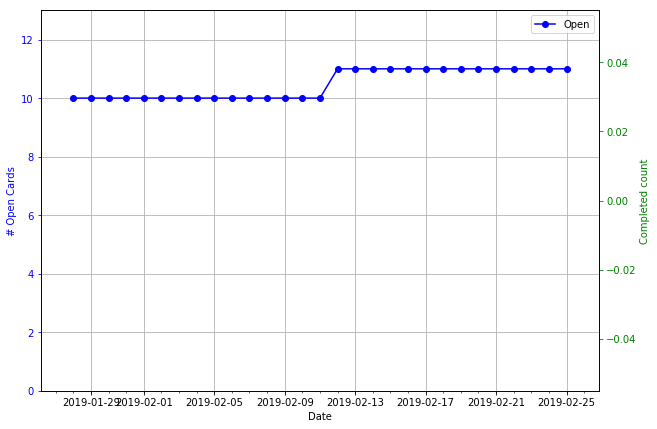

In [ ]:
someday_list_items = list(api.get_all_open_cards(api.TRELLO_SOMEDAY_LIST_ID))
display(HTML('<h1>"Someday / Maybe" items open: {}</h1>'.format(len(someday_list_items))))

dates, open_count, close_count = get_dates_and_counts(api.TRELLO_SOMEDAY_LIST_ID, 28)
plot_historic_counts(dates, open_count, close_count)

card_ages = get_card_ages(someday_list_items)
plot_histogram(card_ages, "Someday Card Ages")
print_oldest_cards(someday_list_items)

display(HTML("<br><br><hr>"))